In [ ]:
!pip install tensorflow matplotlib opencv-python pydot graphviz

In [1]:
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Dense, \
    Concatenate, Add, ReLU, BatchNormalization, AvgPool2D, MaxPool2D, GlobalAvgPool2D, \
    Reshape, Permute, Lambda

In [2]:
def stage(x, channels, repetitions, groups):
    x = shufflenet_block(x, channels, 2, groups) #strides=2 içim
    for _ in range(repetitions):
        x = shufflenet_block(x, channels, 1, groups) #strides=1 için
    return x

In [3]:
def shufflenet_block(tensor, channels, strides, groups):
    x = gconv(tensor, channels // 4, groups)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)
    x = DepthwiseConv2D(3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)

    if strides == 2:
        channels = channels - tensor.shape[-1]

    x = gconv(x, channels, groups)
    x = BatchNormalization()(x)

    if strides == 1:
        x = Add()([tensor, x])
    else:
        avg = AvgPool2D(3, strides=2, padding='same')(tensor)
        x = Concatenate()([avg, x])
    x = ReLU()(x)
    return x

In [4]:
def gconv(tensor, channels, groups):
    input_shape = tf.keras.backend.int_shape(tensor)
    input_ch = input_shape[-1]
    group_ch = input_ch // groups
    output_ch = channels // groups
    groups_list = []

    for i in range(groups):
        #group_tensor = tensor[:, :, :, (i*group_ch): (i+1) * group_ch]
        group_tensor = Lambda(lambda x: x[:, :, :, (i*group_ch): (i+1) * group_ch], output_shape=(input_shape[1], input_shape[2], group_ch))(tensor) #lambda normalinden daha hızlı çalıştığı için hız istnen durumlarda daha çok tercih ediliyor
        group_tensor = Conv2D(output_ch, 1)(group_tensor)
        groups_list.append(group_tensor)
    output = Concatenate()(groups_list)
    return output

In [5]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.shape
    group_ch = channels // groups
    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [6]:
#MODELİ OLUŞTURMAYA BAŞLAYABİLİRİZ

input = Input(shape=(224, 224, 3))  #girdi olarak verilecek veri setinin sahip olması gereken boyutları ve channel sayısını belirtiyor. shufflenet girdi olarak bunu kabul ediyor.
x = Conv2D(24, 3 ,strides=2, padding='same')(input) #24 filters, 3×3 kernel size, strides 2
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D(3, strides=2, padding='same')(x) #3×3 kernel size, strides 2

In [9]:
repetitions = 3, 7, 3 #stage2, stage3, stage4 #stage içerisinde her stage için zorunlu ilk adım olan strides 2'yi yaptırdığım için tekrar sayılarını normalden birer eksik verebiliyorum.
initial_channels = 64
groups = 3

for i, reps in enumerate(repetitions):
    channels = initial_channels * (2**i)
    x = stage(x, channels, reps, groups)

In [10]:
#print("Shape before GlobalAvgPool2D:", x.shape)
x = GlobalAvgPool2D()(x)
#print("Shape after GlobalAvgPool2D:", x.shape)
output = Dense(2, activation='softmax')(x)

from tensorflow.keras import Model
model = Model(input, output)

In [8]:
#MODELİ EĞİTMEK İÇİN VERİ SETLERİNİ ALIP MODELİN İSTEDİĞİ HALE GETİRMEM LAZIM Kİ DOĞRU ÇALIŞABİLSİN --> PREPROCESSING
#Bundan sonraki adımlarda bana gerekecek olan kütüphaneleri ekliyorum

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
#test verisetimde resimler kategorilerine göre klasörlere ayrılmadığından train klasörümdeki verilerin 0.1i kadarını ayrı bir klasöre bölüyorum
#BUNU SADECE VE SADECE BİR KERE ÇALIŞTIRMIŞ VE KLASÖRLERİ AYIRMIŞSAN SAKIN BİR DAHA ÇALIŞTIRMA VERİLERİ TEKRAR TEKRAR KOPYALAYIP DOSYAYI ŞİŞİRİYORSUN ÇÜNKÜ!!! GEREKSİZ VERİ TEKRARI = OVERFITING

import os
import shutil
import random

def split_dataset(source_dir, train_dir, validation_dir, test_dir, train_split=0.7, validation_split=0.2):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            random.shuffle(images)
            train_split_point = int(len(images) * train_split)
            validation_split_point = int(len(images) * (train_split + validation_split))

            train_images = images[:train_split_point]
            validation_images = images[train_split_point:validation_split_point]
            test_images = images[validation_split_point:]

            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(validation_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))

            for image in validation_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(validation_dir, category, image))

            for image in test_images:
                shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))

source_dir = 'datasets/realfakedataset_EASY/fulldatas'
train_dir = 'datasets/realfakedataset_EASY/training'
validation_dir = 'datasets/realfakedataset_EASY/validate'
test_dir = 'datasets/realfakedataset_EASY/testing'

split_dataset(source_dir, train_dir, validation_dir, test_dir)

In [12]:
import os
from PIL import Image

# Function to add padding and resize images
def resize_with_padding(input_folder, output_folder, target_size=(224, 224)):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for category in os.listdir(input_folder):
        category_path = os.path.join(input_folder, category)
        output_category_path = os.path.join(output_folder, category)
        
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        
        for filename in os.listdir(category_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(category_path, filename)
                img = Image.open(image_path)
                
                # Calculate the ratio to maintain aspect ratio
                ratio = min(target_size[0] / img.size[0], target_size[1] / img.size[1])
                new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
                
                # Resize the image
                resized_img = img.resize(new_size, Image.LANCZOS)
                
                # Create a new image with the target size and paste the resized image onto the center
                new_img = Image.new("RGB", target_size, (0, 0, 0))
                new_img.paste(resized_img, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))
                
                # Save the new image
                new_img.save(os.path.join(output_category_path, filename))
                print(f"Saved resized image: {os.path.join(output_category_path, filename)}")

# Define your input and output folders
input_train_folder = 'datasets/realfakedataset_EASY/training'
output_train_folder = 'datasets/realfakedataset_EASY/training224'

input_val_folder = 'datasets/realfakedataset_EASY/validate'
output_val_folder = 'datasets/realfakedataset_EASY/validate224'

input_test_folder = 'datasets/realfakedataset_EASY/testing'
output_test_folder = 'datasets/realfakedataset_EASY/testing224'

# Resize and save images
resize_with_padding(input_train_folder, output_train_folder)
resize_with_padding(input_val_folder, output_val_folder)
resize_with_padding(input_test_folder, output_test_folder)

Saved resized image: datasets/realfakedataset_EASY/training224\fake\1.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\10.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\100.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\101.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\102.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\103.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\104.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\106.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\107.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\109.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\11.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\110.jpg
Saved resized image: datasets/realfakedataset_EASY/training224\fake\113.jpg
Saved resized im

In [13]:
train_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2]
)   #test klasöründen çekemediğim için train verisetinden testlik bir kısım almam gerekti

train_datas = train_generate.flow_from_directory(
    'datasets/realfakedataset_EASY/training224', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1196 images belonging to 2 classes.


In [14]:
validation_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datas = validation_generate.flow_from_directory(
    'datasets/realfakedataset_EASY/validate224', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 341 images belonging to 2 classes.


In [15]:
test_generate = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datas = test_generate.flow_from_directory(
    'datasets/realfakedataset_EASY/testing224',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Type of class labels
    shuffle=False)

Found 172 images belonging to 2 classes.


In [16]:
from tensorflow.keras.optimizers import Adam, SGD

In [17]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

logdir = 'shufflenet_logs' #eğitimle ilgili logların tutulacağı bir klasör oluşturuyoruz
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 112, 112, 24)      │             672 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 112, 112, 24)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 112, 112, 24)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 56, 56, 24)        │               0 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 56, 56, 8)         │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_1 (Lambda)             │ (None, 56, 56, 8)         │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_2 (Lambda)             │ (None, 56, 56, 8)         │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 56, 56, 5)         │              45 │ lambda[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 56, 56, 5)         │              45 │ lambda_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 56, 56, 5)         │              45 │ lambda_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 56, 56, 15)        │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 56, 56, 15)        │              60 │ concatenate[0][0]          │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_1 (ReLU)                │ (None, 56, 56, 15)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 56, 56, 5, 3)      │               0 │ re_lu_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 80,693 (315.21 KB)

 Trainable params: 74,303 (290.25 KB)

 Non-trainable params: 6,390 (24.96 KB)

In [18]:
hist = model.fit(train_datas, epochs=21, validation_data=validation_datas, callbacks=[tensorboard_callback])

Epoch 1/21


C:\Users\ilayd\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5096 - loss: 0.7279 - val_accuracy: 0.5572 - val_loss: 0.6896
Epoch 2/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5295 - loss: 0.6944 - val_accuracy: 0.5103 - val_loss: 0.6924
Epoch 3/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5479 - loss: 0.7002 - val_accuracy: 0.4340 - val_loss: 0.6978
Epoch 4/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 988ms/step - accuracy: 0.5299 - loss: 0.7045 - val_accuracy: 0.4370 - val_loss: 0.6980
Epoch 5/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 995ms/step - accuracy: 0.5180 - loss: 0.6969 - val_accuracy: 0.4897 - val_loss: 0.6941
Epoch 6/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 996ms/step - accuracy: 0.5379 - loss: 0.6953 - val_accuracy: 0.5484 - val_loss: 0.6907
Epoch 7/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5813 - loss: 0.6905 - val_accuracy: 0.4780 - val_loss: 0.6954
Epoch 8/21
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5346 - loss: 0.6934 - val_accuracy: 0.5572 - val_loss: 

In [19]:
hist.history

{'accuracy': [0.5200669169425964,
  0.52173912525177,
  0.5334448218345642,
  0.5418060421943665,
  0.5200669169425964,
  0.5351170301437378,
  0.5493311285972595,
  0.5401337742805481,
  0.535953164100647,
  0.5367892980575562,
  0.5568562150001526,
  0.5334448218345642,
  0.5443143844604492,
  0.532608687877655,
  0.5234113931655884,
  0.5066889524459839,
  0.554347813129425,
  0.5484949946403503,
  0.5443143844604492,
  0.5476588606834412,
  0.5660535097122192],
 'loss': [0.7167324423789978,
  0.6974819302558899,
  0.7085654139518738,
  0.6970160007476807,
  0.6989786624908447,
  0.6922343373298645,
  0.6954478025436401,
  0.6946998834609985,
  0.6935182809829712,
  0.6938803195953369,
  0.6879398226737976,
  0.6962778568267822,
  0.6858058571815491,
  0.6952809691429138,
  0.6996976137161255,
  0.7060148119926453,
  0.6871410608291626,
  0.6916906833648682,
  0.6947058439254761,
  0.6888450384140015,
  0.6860170364379883],
 'val_accuracy': [0.5571847558021545,
  0.5102639198303223,

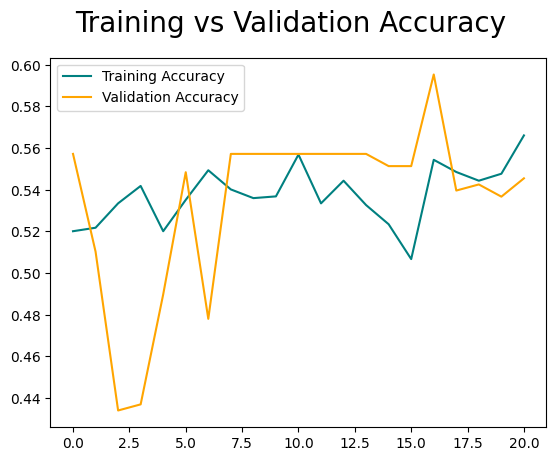

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
fig.suptitle('Training vs Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

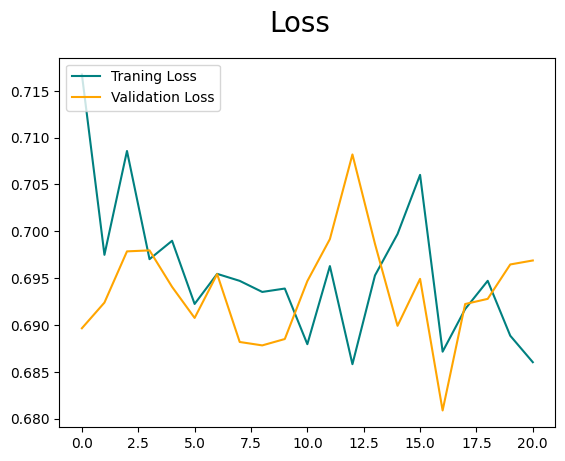

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Traning Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
import numpy as np
num_batches = len(test_datas)
batch_size = test_datas.batch_size
total_samples = test_datas.samples

# Calculate the number of steps (batches)
steps = total_samples // batch_size
if total_samples % batch_size != 0:
    steps += 1  # If there are remaining samples, add one more step

# Initialize lists to hold true and predicted labels
y_true = []
y_pred = []

# Iterate over the test data
for step in range(steps):
    X, y = next(test_datas)
    yhat = model.predict(X)
    y_true.extend(np.argmax(y, axis=1))  # Assuming y is one-hot encoded
    y_pred.extend(np.argmax(yhat, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='binary') 

recall = recall_score(y_true, y_pred, average='binary')  

f1 = f1_score(y_true, y_pred, average='binary')  

cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.5523255813953488
Precision: 0.56
Recall: 0.8842105263157894
F1 Score: 0.6857142857142857
Confusion Matrix:
[[11 66]
 [11 84]]


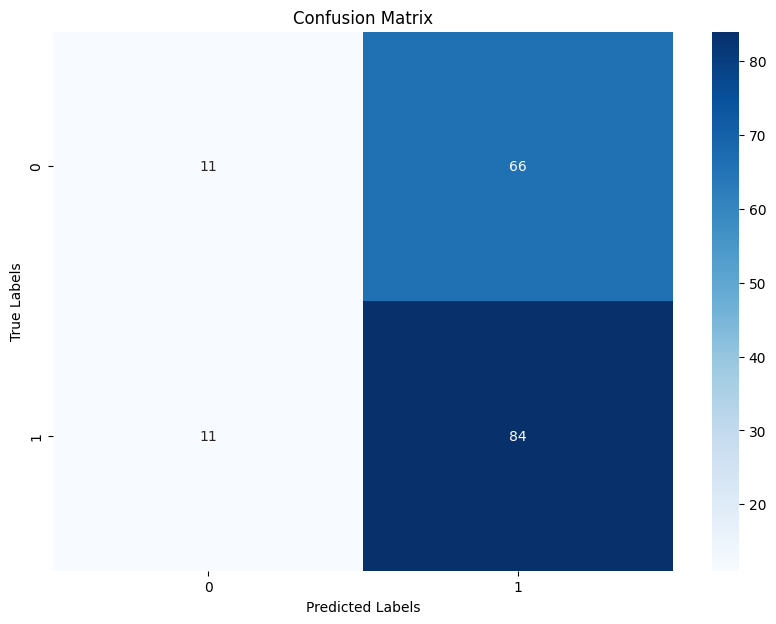

In [24]:
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
model.save(os.path.join('shufflenet_models/foreasydataset', 'accur05816valacc05572.h5'))